In [1]:
import pandas as pd
import pyBigWig
import numpy as np
import seaborn as sns
import re
from liftover import get_lifter
data='/labs/mpsnyder/moqri/data/index/'
datam='/labs/mpsnyder/moqri/data/mont/'

ch=1

v='38'
h9_bw='http://smithdata.usc.edu/methbase/data/Xie-Human-2013/Human_H9/tracks_hg'+v+'/Human_H9.meth.bw'
ips_bw='http://smithdata.usc.edu/methbase/data/Lister-iPSC-2011/Human_FFiPSC69/tracks_hg'+v+'/Human_FFiPSC69.meth.bw'
ezh_h9='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE76nnn/GSE76626/suppl/GSE76626_ChIP-Seq_RPM.txt.gz' ## hg38

ct_bw='http://smithdata.usc.edu/methbase/data/Heyn-Human-NewbornCentenarian-2012/Human_CD4T-100yr/tracks_hg'+v+'/Human_CD4T-100yr.meth.bw'
nb_bw='http://smithdata.usc.edu/methbase/data/Heyn-Human-NewbornCentenarian-2012/Human_CD4T-Newborn/tracks_hg'+v+'/Human_CD4T-Newborn.meth.bw'
so_bw='http://smithdata.usc.edu/methbase/data/Vandiver-Human-2015/Human_Epidermis-old-sun-exposed/tracks_hg'+v+'/Human_Epidermis-old-sun-exposed.meth.bw'
sy_bw='http://smithdata.usc.edu/methbase/data/Vandiver-Human-2015/Human_Epidermis-young-sun-exposed/tracks_hg'+v+'/Human_Epidermis-young-sun-exposed.meth.bw'


hg19tohg38='http://hgdownload.soe.ucsc.edu/goldenPath/hg19/liftOver/hg19ToHg38.over.chain.gz'

def bw2df(cell,ch):
    df=bws[cell].intervals("chr"+str(ch))
    print(len(df))
    df=pd.DataFrame(df)
    df.index=df[0]
    df=df[2]
    dfs.append(df)    
    return(dfs)
def bw2df(cell):
    bw=cell
    bw=pyBigWig.open(bw)
    bws=[]
    for i,r in ezh.iterrows():
        print('',end='.')
        bwi=bw.intervals("chr"+str(r['chrom']),r['chromStart'],r['chromEnd'])
        if bwi is not None:
            for b in bwi:
                bws.append([r['chrom'],b[0],b[2]])
    df=pd.DataFrame(bws)
    print(df.shape)
    return df

In [2]:
ezh=pd.read_table(ezh_h9,index_col=0)
ezh=ezh[['Chromosome','Start','End','WT_EZH2','Strand']][ezh['WT_EZH2']>1]
ezh.columns=['chrom', 'chromStart', 'chromEnd', 'value','s']
ezh=ezh[~ezh.index.str.contains('-AS')]
ezh=ezh[ezh.index.str.contains('001')]
ezh=ezh[ezh.chrom!='X']
ezh.index=ezh.index.str.strip('-001_upstream')
print(ezh.shape)
ezh['d']=ezh.chromEnd-ezh.chromStart
ezh.d.sum()/1000000

(929, 5)


/home/moqri/anaconda3/envs/stem/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


4.645

In [3]:
ezh['tss']=(ezh.chromStart+ezh.chromEnd)/2

In [4]:
dfs=[]
cells=[h9_bw,ips_bw,nb_bw,ct_bw,sy_bw,so_bw]
bws={}
for cell in cells:
    bws[cell]=pyBigWig.open(cell)
    df=bw2df(cell)
    dfs.append(df)

.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................(245711, 3)
...........................................................

In [16]:
for df in dfs:
    df.drop_duplicates(inplace=True)
    df.index=df[0].astype(str)+'_'+df[1].astype(str)
    df.drop([0,1],1,inplace=True)    

<ipython-input-16-b6135f2ef505>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop([0,1],1,inplace=True)


In [18]:
for i in range(6):
    dfs[i].columns=[['h','i','n','c','y','o'][i]]

In [21]:
dg=dfs[0]
for df in dfs[1:]:
    dg=dg.merge(df,left_index=True,right_index=True,how='left')

<AxesSubplot:>

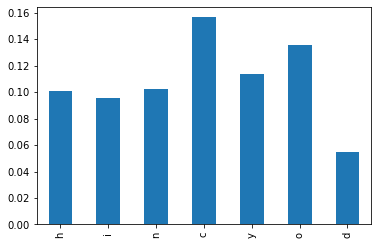

In [66]:
dg.mean().plot(kind='bar')

In [32]:
#dg.to_csv('ezs.csv')

In [5]:
df=pd.read_csv('ezs.csv',index_col=0)
df.shape

(210130, 6)

In [15]:
tss=(ezh.chrom.astype(int)*10**9+ezh.tss).values

In [24]:
df['g']=df.index.str.split('_').str[0].astype(int)*10**9+df.index.str.split('_').str[1].astype(int)

In [35]:
df['tss']=df.g.apply(lambda y:min(tss, key=lambda x:abs(x-y)))

In [36]:
df['d']=df.g-df.tss

<AxesSubplot:>

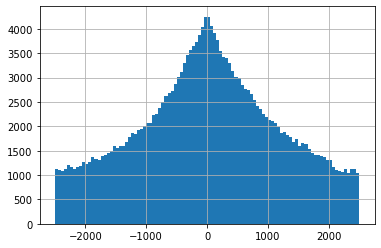

In [39]:
df.d.hist(bins=100)

In [363]:
df['dq']=pd.qcut(df.d,11)
df[df.h<.5].groupby('dq').mean()[['h','n','c','i']]

,h,n,c,i
dq,,,,
"(-2500.001, -1711.0]",0.063285,0.088203,0.158899,0.057123
"(-1711.0, -1126.0]",0.049807,0.072160,0.141539,0.053122
"(-1126.0, -689.0]",0.042056,0.051022,0.109027,0.046698
"(-689.0, -359.0]",0.033355,0.037051,0.090744,0.035786
"(-359.0, -97.0]",0.023394,0.026790,0.074822,0.027245
"(-97.0, 134.0]",0.020017,0.023141,0.063336,0.021857
"(134.0, 407.0]",0.026165,0.030157,0.078972,0.028143
"(407.0, 739.0]",0.034907,0.041556,0.100101,0.037154
"(739.0, 1161.0]",0.042400,0.058035,0.123976,0.046273


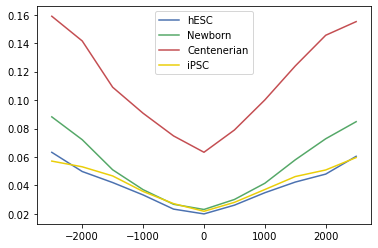

In [353]:
pl=df[df.h<.5].groupby('dq').mean()[['h','n','c','i']]
pl.columns=['hESC','Newborn','Centenerian','iPSC']
pl.index=list(range(-2500,2501,500))
ax=sns.lineplot(data=pl,dashes=False,palette = sns.color_palette(["#4c72b0","#55a868","#c44e52","#EACE09"]))

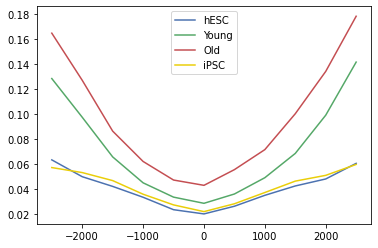

In [354]:
pl=df[df.h<.5].groupby('dq').mean()[['h','y','o','i']]
pl.columns=['hESC','Young','Old','iPSC']
pl.index=list(range(-2500,2501,500))
ax=sns.lineplot(data=pl,dashes=False,palette = sns.color_palette(["#4c72b0","#55a868","#c44e52","#EACE09"]))

In [63]:
man='https://zhouserver.research.chop.edu/InfiniumAnnotation/20180909/HM450/HM450.hg38.manifest.tsv.gz'
man=pd.read_table(man)

In [64]:
man=man[~man.CpG_chrm.isna()][man.CpG_chrm!='chrX'][man.CpG_chrm!='chrY'][man.CpG_chrm!='chrM']
man['CpG_chrm']=man.CpG_chrm.str[3:].astype(float)

<ipython-input-64-cad03d9984f6>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  man=man[~man.CpG_chrm.isna()][man.CpG_chrm!='chrX'][man.CpG_chrm!='chrY'][man.CpG_chrm!='chrM']


In [65]:
man.index=man.CpG_chrm.astype(int).astype(str)+'_'+man.CpG_beg.astype(int).astype(str)

In [379]:
ll=man.loc[df[df.h<.5].index.intersection(man.index)][['probeID']]
ll['dq']=df.loc[ll.index].dq
ll.shape

(12743, 2)

In [177]:
liver450='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48325/matrix/GSE48325_series_matrix.txt.gz'
!wget -q -nc {liver450} -O {datam}\liver450.gz

In [ ]:
n=6

(485577, 85)


<AxesSubplot:>

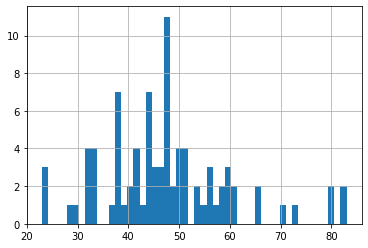

In [366]:
liver=pd.read_csv(liver450, index_col=0,sep='\t', skiprows=60,nrows=10**n)
liver=liver.drop('!series_matrix_table_end')
print(liver.shape)
l_ages=pd.read_csv(liver450, index_col=0,sep='\t', skiprows=27,nrows=9).iloc[8].str.strip('age: ').astype(float)
l=liver.T
l['age']=l_ages
l.age.hist(bins=50)

In [367]:
l['age']=pd.cut(l.age,[20,30,40,50,60])

In [368]:
l['age'].value_counts().sort_values()

(20, 30]     5
(50, 60]    16
(30, 40]    19
(40, 50]    35
Name: age, dtype: int64

In [369]:
l=l.groupby('age').mean()

In [370]:
l=l[ll.probeID].T

In [380]:
l['dq']=ll.dq.values

In [381]:
pl=l.groupby('dq').mean()
pl.index=list(range(-2500,2501,500))

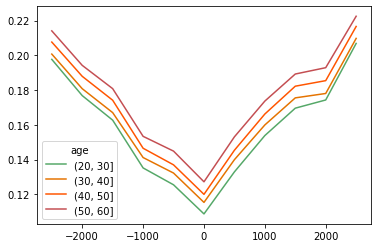

In [386]:
ax=sns.lineplot(data=pl,dashes=False,palette = sns.color_palette(["#55a868","#E57300","#FF5500","#c44e52"]))